Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

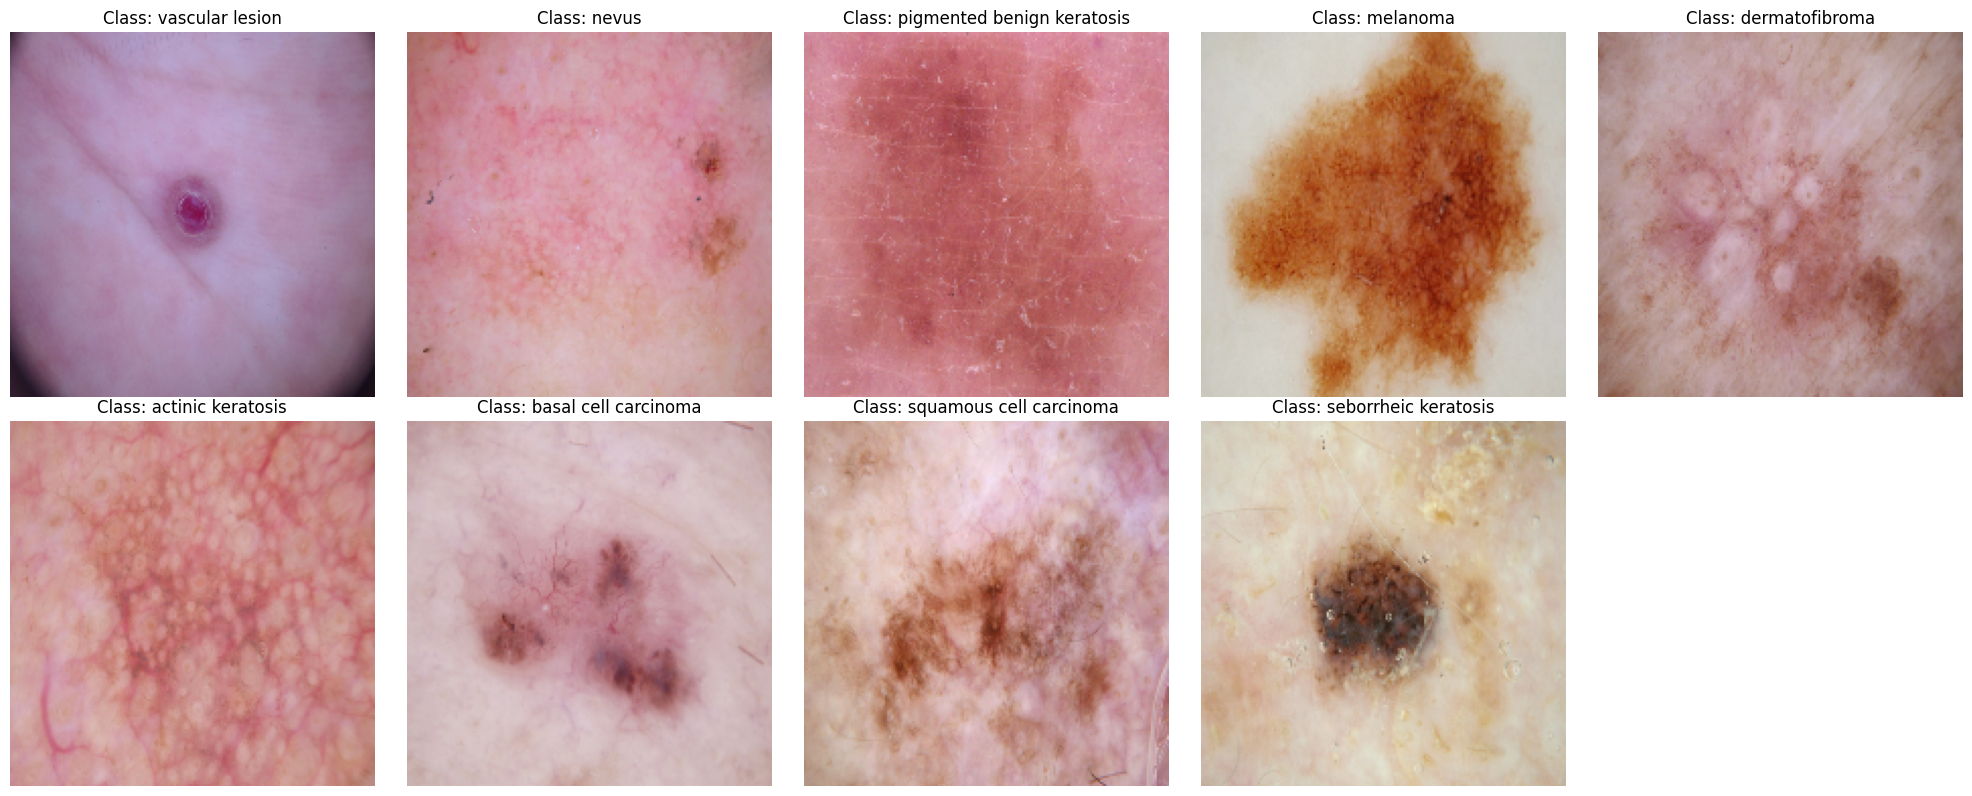

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

# plotting some random 9 images

# Dictionary to store one sample per class
class_samples = {}

# Iterate through the dataset
for images, labels in train_ds:
    # Loop through each image and label in the batch
    for image, label in zip(images, labels):
        label_value = label.numpy()

        # If this label is not yet in the dictionary, add it
        if label_value not in class_samples:
            class_samples[label_value] = image

        # Break out of the loop if we have one image for each class
        if len(class_samples) == train_ds.class_names:
            break

    # Break outer loop if all classes are covered
    if len(class_samples) == len(train_ds.class_names):
        break


# Calculate the number of columns needed for 2 rows
num_classes = len(class_samples)
num_columns = math.ceil(num_classes / 2)  # Divide by 2 rows

# Create a plot with 2 rows and the calculated number of columns
fig, axes = plt.subplots(2, num_columns, figsize=(num_columns * 4, 8))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot one image for each class
for idx, (class_label, image) in enumerate(class_samples.items()):
    ax = axes[idx]
    ax.imshow(image.numpy().astype("uint8"))
    ax.set_title(f'Class: {train_ds.class_names[class_label]}')
    ax.axis('off')

# Remove any unused subplots (if num_classes is odd)
for ax in axes[num_classes:]:
    fig.delaxes(ax)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# Define the Rescaling layer to normalize pixel values to [0, 1]
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Apply rescaling to the training and validation datasets
train_dataset = train_ds.map(lambda x, y: (rescale_layer(x), y))
val_dataset = val_ds.map(lambda x, y: (rescale_layer(x), y))

In [12]:
### Your code goes here
model_1 = models.Sequential()

# 1st Convolutional Block
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model_1.add(layers.BatchNormalization())
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(Dropout(0.20))

# 2nd Convolutional Block
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.BatchNormalization())
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(Dropout(0.20))

# 3rd Convolutional Block
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.BatchNormalization())
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(Dropout(0.20))

# Flatten and Fully Connected Layers
model_1.add(layers.Flatten())
model_1.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(layers.BatchNormalization())
model_1.add(layers.Dropout(0.5))

# Output Layer (for 9 classes)
model_1.add(layers.Dense(9, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 87, 87, 64)        2

### Train the model

In [15]:
epochs = 20
history = model_1.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 41s 500ms/step - loss: 5.6867 - accuracy: 0.3655 - val_loss: 7.7447 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 22s 388ms/step - loss: 4.0766 - accuracy: 0.4643 - val_loss: 5.6750 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 22s 384ms/step - loss: 3.0080 - accuracy: 0.4760 - val_loss: 5.4448 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 22s 384ms/step - loss: 2.6643 - accuracy: 0.4743 - val_loss: 4.3403 - val_accuracy: 0.2304
Epoch 5/20
56/56 [==============================] - 21s 380ms/step - loss: 2.4835 - accuracy: 0.4978 - val_loss: 4.2515 - val_accuracy: 0.2438
Epoch 6/20
56/56 [==============================] - 21s 380ms/step - loss: 2.2872 - accuracy: 0.4994 - val_loss: 3.7576 - val_accuracy: 0.2864
Epoch 7/20
56/56 [==============================] - 21s 373ms/step - loss: 2.2672 - accuracy: 0.5190 - val_loss: 3.3991 - val_accuracy: 0.1611

### Visualizing training results

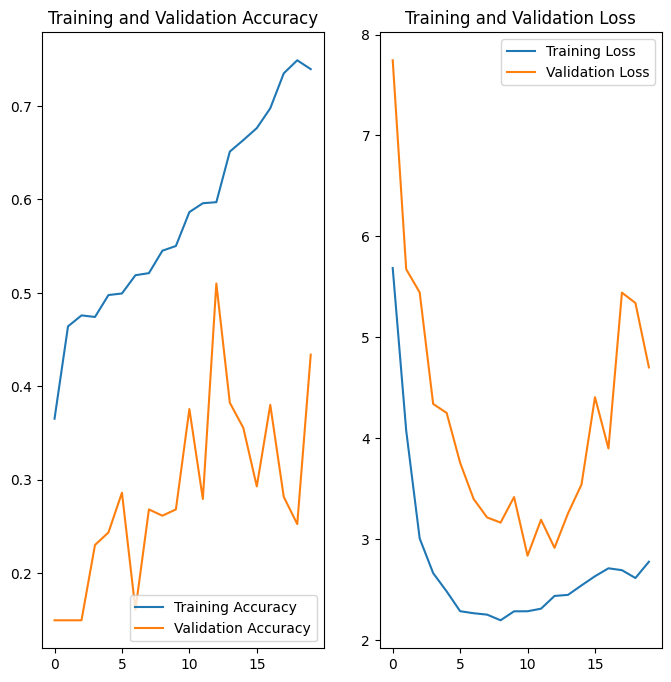

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

There is overfitting in the model. as the epoch is increasing, so is the gap between train and validation.

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
#Data augumentation strategy.

# Define augmentation using Keras layers
augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),   # Randomly flip horizontally and vertically
    tf.keras.layers.RandomRotation(0.2),                     # Randomly rotate images by 10% radians
    tf.keras.layers.RandomZoom(0.2),                         # Random zoom between 80% and 120%
    tf.keras.layers.RandomBrightness(0.2),                   # Adjust brightness by max 20%
    tf.keras.layers.RandomContrast(0.2)                      # Randomly adjust contrast
])

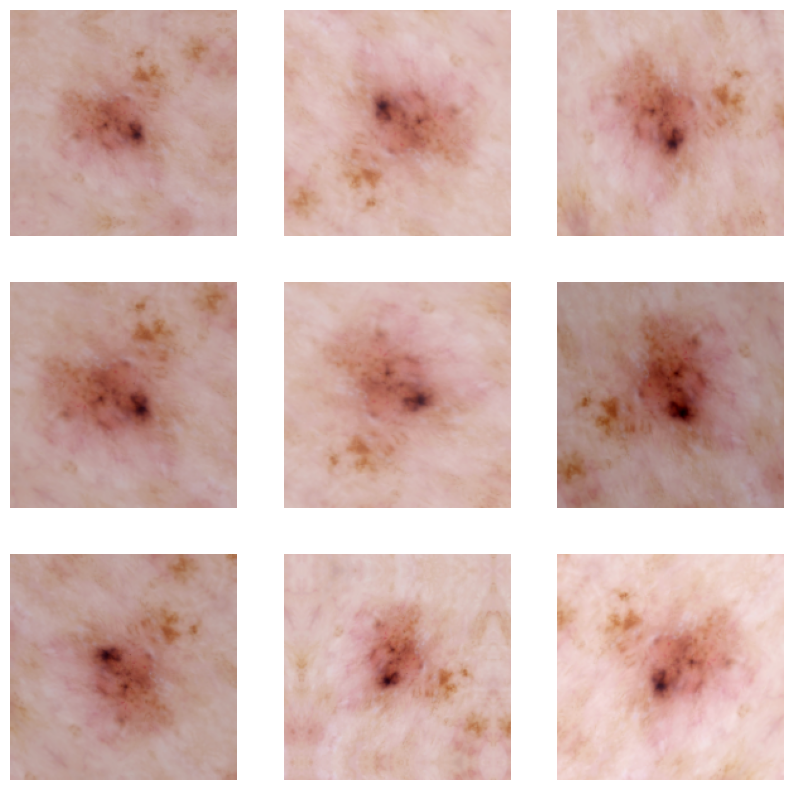

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

#Visualize the augmentation image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_layer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
# Function to apply augmentations
def augment(image, label):
    image = augmentation_layer(image)  # Apply the augmentations
    return image, label

# Apply augmentation to the training dataset
train_dataset_aug = train_ds.map(augment)

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model_2 = models.Sequential()

# 1st Convolutional Block
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(Dropout(0.20))

# 2nd Convolutional Block
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(Dropout(0.20))

# 3rd Convolutional Block
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(Dropout(0.20))

# Flatten and Fully Connected Layers
model_2.add(layers.Flatten())
model_2.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.5))

# Output Layer (for 9 classes)
model_2.add(layers.Dense(9, activation='softmax'))

### Compiling the model

In [21]:
## Your code goes here

model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_2.fit(
  train_dataset_aug,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 23s 384ms/step - loss: 5.7727 - accuracy: 0.3075 - val_loss: 7.9011 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 21s 379ms/step - loss: 4.1583 - accuracy: 0.3605 - val_loss: 3.6204 - val_accuracy: 0.3960
Epoch 3/20
56/56 [==============================] - 21s 377ms/step - loss: 3.2457 - accuracy: 0.3856 - val_loss: 2.6770 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 21s 380ms/step - loss: 2.7888 - accuracy: 0.4135 - val_loss: 2.5130 - val_accuracy: 0.3736
Epoch 5/20
56/56 [==============================] - 21s 379ms/step - loss: 2.6251 - accuracy: 0.4007 - val_loss: 2.3221 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 21s 379ms/step - loss: 2.5497 - accuracy: 0.4230 - val_loss: 2.6401 - val_accuracy: 0.3937
Epoch 7/20
56/56 [==============================] - 21s 376ms/step - loss: 2.4162 - accuracy: 0.4330 - val_loss: 2.2229 - val_accuracy: 0.4228

### Visualizing the results

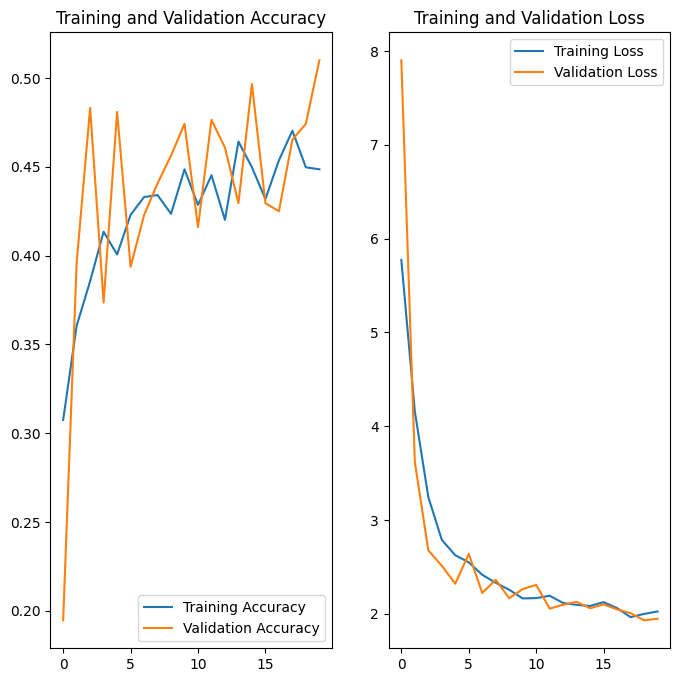

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The overfitting problem is not there after data augmentation but the accuracy of the model drops significantly. Also there seems to be a little underfitting in the model now.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.

def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df = df.sort_values(by='No. of Image', ascending=False)
df

,Class,No. of Image
7,pigmented benign keratosis,462
0,melanoma,438
5,basal cell carcinoma,376
8,nevus,357
1,squamous cell carcinoma,181
2,vascular lesion,139
4,actinic keratosis,114
3,dermatofibroma,95
6,seborrheic keratosis,77


<Axes: xlabel='No. of Image', ylabel='Class'>

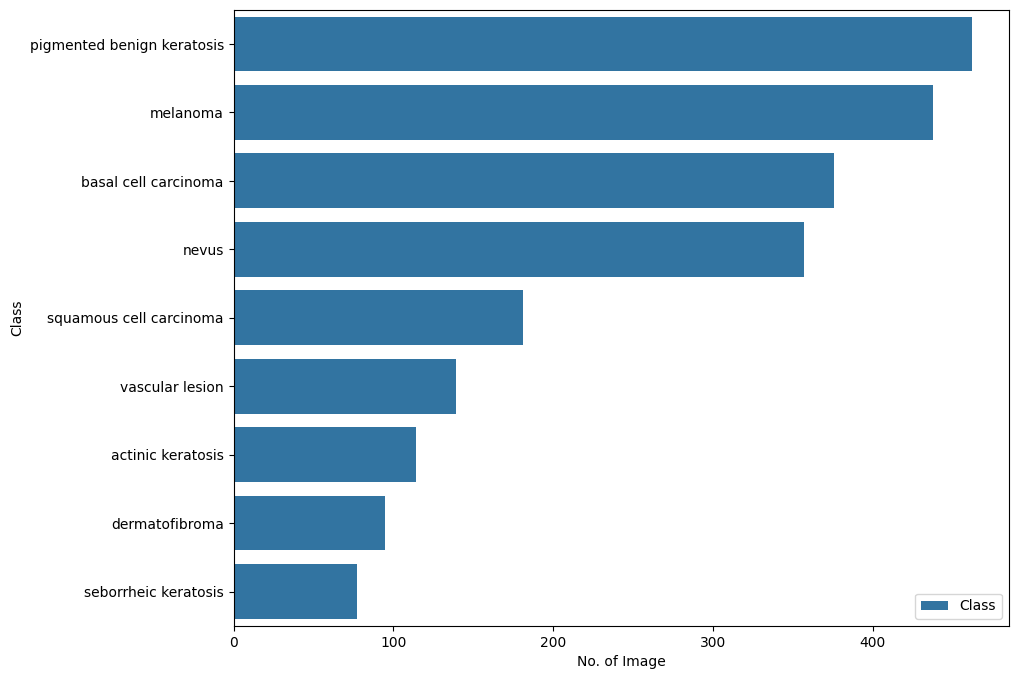

In [25]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


From the above we can see **seborrheic keratosis** has the least number of samples. Also, **pigmented benign keratosis**, **melanoma**, **basal cell carcinoma** and **nevus** dominate the data.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="/content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DDC0C5EB7C0>: 100%|██████████| 500/500 [00:04<00:00, 107.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DDC0C5E8850>: 100%|██████████| 500/500 [00:04<00:00, 107.31 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DDD9450EE00>: 100%|██████████| 500/500 [00:05<00:00, 97.33 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DDC0C7A81C0>: 100%|██████████| 500/500 [00:06<00:00, 75.42 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DDC0C573730>: 100%|██████████| 500/500 [00:06<00:00, 75.59 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DDC0C46A320>: 100%|██████████| 500/500 [00:04<00:00, 103.37 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DDC0C42CA60>: 100%|██████████| 500/500 [00:05<00:00, 97.19 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DDD940E1E40>: 100%|██████████| 500/500 [00:04<00:00, 101.00 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DDD942FC7F0>: 100%|██████████| 500/500 [00:05<00:00, 96.76 Samples/s] 


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010516.jpg_9f37aa3b-5159-4939-8fbb-f787df024d30.jpg',
 '/content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011185.jpg_4dc58d56-b07c-479b-a4a2-a1d0ecfc8feb.jpg',
 '/content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010587.jpg_38bb822b-22c1-4861-8c78-ead45614d934.jpg',
 '/content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000516.jpg_24bbe57f-f8b0-44eb-87c6-e3f9f168b110.jpg',
 '/content/drive/MyDrive/Data Scienc

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [34]:
df2['Label'].value_counts()

,count
Label,
melanoma,500
squamous cell carcinoma,500
vascular lesion,500
dermatofibroma,500
actinic keratosis,500
basal cell carcinoma,500
seborrheic keratosis,500
pigmented benign keratosis,500
nevus,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train="/content/drive/MyDrive/Data Science/Upgrad/Deep Learning/Melenoma Classifier/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [38]:
# Define the Rescaling layer to normalize pixel values to [0, 1]
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Apply rescaling to the training and validation datasets
train_dataset_class_bal = train_ds.map(lambda x, y: (rescale_layer(x), y))
val_dataset_class_bal = val_ds.map(lambda x, y: (rescale_layer(x), y))

#### **Todo:** Create your model (make sure to include normalization)

In [39]:
## your code goes here

model_3 = models.Sequential()

# 1st Convolutional Block
model_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.BatchNormalization())
model_3.add(Dropout(0.20))

# 2nd Convolutional Block
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.BatchNormalization())
model_3.add(Dropout(0.20))

# 3rd Convolutional Block
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.BatchNormalization())
model_3.add(Dropout(0.20))

# Flatten and Fully Connected Layers
model_3.add(layers.Flatten())
model_3.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dropout(0.5))

# Output Layer (for 9 classes)
model_3.add(layers.Dense(9, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [40]:
## your code goes here

model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [41]:
epochs = 44

history = model_3.fit(
  train_dataset_class_bal,
  validation_data=val_dataset_class_bal,
  epochs=epochs
)

Epoch 1/44
169/169 [==============================] - 52s 292ms/step - loss: 4.2969 - accuracy: 0.3678 - val_loss: 3.7127 - val_accuracy: 0.2376
Epoch 2/44
169/169 [==============================] - 49s 289ms/step - loss: 2.5052 - accuracy: 0.4332 - val_loss: 3.3702 - val_accuracy: 0.1626
Epoch 3/44
169/169 [==============================] - 49s 287ms/step - loss: 2.2777 - accuracy: 0.4599 - val_loss: 2.6086 - val_accuracy: 0.2918
Epoch 4/44
169/169 [==============================] - 49s 289ms/step - loss: 2.1898 - accuracy: 0.4750 - val_loss: 2.7400 - val_accuracy: 0.3155
Epoch 5/44
169/169 [==============================] - 49s 290ms/step - loss: 2.1727 - accuracy: 0.4909 - val_loss: 2.8472 - val_accuracy: 0.3163
Epoch 6/44
169/169 [==============================] - 49s 287ms/step - loss: 2.2299 - accuracy: 0.5121 - val_loss: 2.2648 - val_accuracy: 0.4863
Epoch 7/44
169/169 [==============================] - 49s 285ms/step - loss: 2.2355 - accuracy: 0.5425 - val_loss: 2.6057 - val_ac

#### **Todo:**  Visualize the model results

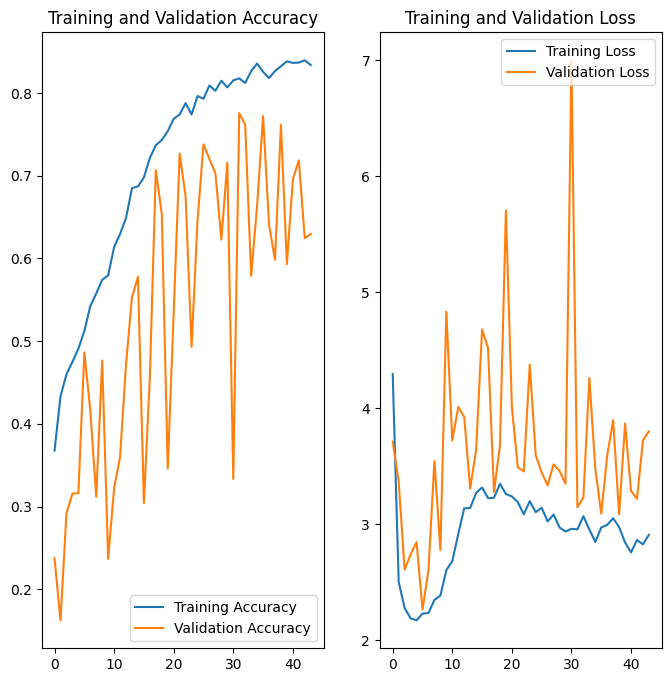

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [52]:
history_1 = model_1.history.history  # Replace with actual history from model 1
history_2 = model_2.history.history  # Replace with actual history from model 2
history_3 = model_3.history.history  # Replace with actual history from model 3

# Create a dictionary to store the metrics for the 20th epoch of Model 1
data_1 = {
    'Epoch': [20],  # 20th epoch
    'Model': ['Base Model'],
    'Train Accuracy': [history_1['accuracy'][19]],  # Index 19 for 20th epoch (0-indexed)
    'Validation Accuracy': [history_1['val_accuracy'][19]],
    'Train Loss': [history_1['loss'][19]],
    'Validation Loss': [history_1['val_loss'][19]]
}

# Create a dictionary to store the metrics for the 20th epoch of Model 2
data_2 = {
    'Epoch': [20],  # 20th epoch
    'Model': ['Model with Data Augmentation'],
    'Train Accuracy': [history_2['accuracy'][19]],  # Index 19 for 20th epoch (0-indexed)
    'Validation Accuracy': [history_2['val_accuracy'][19]],
    'Train Loss': [history_2['loss'][19]],
    'Validation Loss': [history_2['val_loss'][19]]
}

# Create a dictionary to store the metrics for the 32th epoch of Model 3
data_3 = {
    'Epoch': [32],  # 32th epoch
    'Model': ['Model with Class Rebalance'],
    'Train Accuracy': [history_3['accuracy'][31]],  # Index 31 for 32th epoch (0-indexed)
    'Validation Accuracy': [history_3['val_accuracy'][31]],
    'Train Loss': [history_3['loss'][31]],
    'Validation Loss': [history_3['val_loss'][31]]
}

# Convert the dictionaries into pandas DataFrames
df_1 = pd.DataFrame(data_1)
df_2 = pd.DataFrame(data_2)
df_3 = pd.DataFrame(data_3)

# Combine the DataFrames into one DataFrame
df_all = pd.concat([df_1, df_2, df_3], axis=0)

# Display the Dataframe
from IPython.display import display, HTML
display(HTML(df_all.to_html(index=False)))


Epoch,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
20,Base Model,0.739397,0.434004,2.777401,4.702516
20,Model with Data Augmentation,0.448661,0.510067,2.025355,1.948084
32,Model with Class Rebalance,0.817693,0.775798,2.956851,3.147507
